<h1><center>Modelo Financiero</center></h1>

In [1]:
#Librerias
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxopt as cvx
from cvxopt import matrix, solvers

In [2]:
path='C:/Users/Brayan Jair.Brayan-Jair-PC/Documents/Ángela/Python/acciones/'
#path ='C:/Users/Brayan Jair/Documents/Universidad/Maestría en Actuaría y finanzas/proyecto investigación Maestría/Python/acciones/'    
#path ='D:/Dropbox/Universidad/Maestría en Actuaría y finanzas/proyecto investigación Maestría/Python/acciones/'

In [3]:
#################################################
#  Matriz de precios de cierre de las acciones  #
#################################################

def Lec(path):                                                                           #Lectura de archivos .csv
    allFiles = glob.glob(path + "/*.csv")
    Data = []
    Completname = []
            
    for file_ in allFiles:                                  
        Completname.append(file_[144:-4])                                                #Vector de nombres de los archivos
        Data.append(pd.read_csv(file_, header=0, skiprows=range(1,int(0.3*len(file_))))) #skiprows=[int(0.3*len(file_))] selecciona el subconjunto de datos de entrenamiento
    return(Data,Completname)


def ArcM(Data):                                                                          #identifica el archivo con más filas
    filas=[]
    for i in range(len(Data)):
        filas.append(Data[i].shape[0])
    IndArchMax = filas.index(max(filas))
    return(IndArchMax)


def Sizequal(Data):                                                                     #Compara tamaños de archivos y los vuelve de igual tamaño
    for j in range(len(Data)):
        dif = Data[ArcM(Data)].shape[0] - Data[j].shape[0]
        
        if dif != 0:
            Data[j] = Data[j].append([Data[ArcM(Data)].iloc[:dif,:]]).reset_index(drop=True)
    return(Data)

def CompleT(Data):                                                                      #Completa cada dataFrame con la información adecuada
    for j in range(len(Data)):
        for i in range(Data[0].shape[0]):
            if Data[0].iloc[i, 0]!=Data[j].iloc[i, 0]:
                row=pd.DataFrame([[Data[0].iloc[i, 0], Data[j].iloc[i-1, 1],Data[j].iloc[i-1, 2],Data[j].iloc[i-1, 3], Data[j].iloc[i-1, 4],Data[j].iloc[i-1, 5],Data[j].iloc[i-1, 6]]], columns=['Fecha', 'Último', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', '% var.'])
                Data[j] = pd.concat([Data[j].iloc[:i,:], row, Data[j].iloc[i:,:]]).reset_index(drop=True)
                Data[j]=Data[j].drop(Data[j].index[Data[0].shape[0]])
        
    return(Data)

 

def Sel(Data):                                                                          #Matriz de los precios de cierre de las acciones
    Pc=np.asarray([])
    flagFirst = 0
        
    for k in range(len(Data)):
        CloPrice  = Data[k].iloc[:,1].values    
        CloPrice = [s. replace('.','') for s in CloPrice] 
        CloPrice = [s. replace(',','.') for s in CloPrice]
        v = [float(s) for s in CloPrice] 
        
        if flagFirst==0:
            flagFirst = 1
            Pc = v
        else:
            Pc = np.vstack((Pc,v)) #"pega verticalmente"
    return(Pc)

Closing_Price=Sel(CompleT(Sizequal(Lec(path)[0])))
print(Closing_Price)
print(np.shape(Closing_Price))

[[19680. 19460. 19360. ... 20960. 20740. 20820.]
 [19460. 17080. 17620. ... 19000. 19060. 19140.]
 [19460.  2400.  2420. ...  3000.  3010.  2980.]
 ...
 [19060. 19060. 19060. ...  6300.  6100.  6100.]
 [37120. 36420. 36160. ... 41380. 41440. 41480.]
 [19460. 35220. 34980. ... 40380. 40220. 40340.]]
(26, 217)


In [4]:
#############################
# Cálculo precios relativos #
#############################

def retorn(M):
    M=np.transpose(M)
    vt=np.zeros((M.shape[0], M.shape[1]))
            
    for i in range(M.shape[1]):
        for j in range(M.shape[0]):
            vt[j][i] = M[j-1][i] /M[j][i] #Cálculo de vt (según artículo guía)
    
    Vt=np.transpose(np.delete(vt,0,0))
    onesColumn = np.ones((1,Vt.shape[1]));
    Vt = np.vstack((onesColumn,Vt)) # ubica elementos en la parte inferior - en este caso ubica filas-
    #plt.matshow(V_t)
    return Vt

In [5]:
####################################################################################
# Media, Varianza, y Matriz de covarianzas de los precios de cierre de cada acción #
####################################################################################

Me = np.mean(Closing_Price, axis = 1)
Va = np.var(Closing_Price, axis=1) # ddof es para que divida sobre (N - ddof)
Co = np.cov(Closing_Price)

print(Va)
print(Co)

Lambda = (-np.mean(Me)/(np.matmul(np.transpose(Me),np.matmul(np.linalg.inv(Co),Me))))   #Lagrangiano
q = matrix(Lambda*Me,(Co.shape[0],1))
#print(q)
#print(np.transpose(np.asarray(q)))

[5.40347597e+05 1.02413151e+06 1.31165248e+06 2.29529141e+07
 3.99170018e+06 4.90909700e+06 8.58967844e+05 2.10094559e+06
 1.04508623e+06 5.33206061e+06 9.63825288e+06 1.65576394e+06
 1.04045351e+06 1.51627421e+06 5.82607931e+06 3.69995554e+05
 8.77883370e+02 1.23035640e+07 1.55537075e+06 1.55899450e+06
 3.87068199e+05 1.96012334e+05 2.20147516e+05 2.52380392e+06
 2.45062534e+06 4.84342247e+06]
[[ 5.42849206e+05  6.62461905e+05 -8.96759259e+02 -2.41708995e+04
  -5.03802646e+05 -2.70329365e+05  6.24743386e+05  4.45599471e+05
   1.85654762e+04  1.40772682e+06 -2.09992434e+05  7.99638889e+05
   1.28247619e+05 -3.43059861e+04 -4.64074339e+05 -2.95100265e+05
  -5.95284392e+03 -3.06857791e+05 -9.04761905e+02 -1.50978836e+03
   5.26653439e+04  4.44642857e+04  2.10618254e+05 -1.08977249e+05
   1.00268968e+06  1.24152460e+06]
 [ 6.62461905e+05  1.02887286e+06  1.16730929e+05 -5.02193497e+05
  -7.49278418e+05 -4.86877923e+05  8.30254224e+05  7.95518928e+05
   1.74885644e+05  2.15583830e+06  7.15

NameError: name 'matrix' is not defined

(array([ 0.05992585,  0.00948652,  0.34425563,  0.07046989, -0.09323399,
        0.0377725 , -0.18914845, -0.00759027,  0.27037786, -0.04412031,
        0.00294549, -0.11537351,  0.33337142,  0.3522573 ,  0.07322114,
       -0.29538124,  0.67702729, -0.01032728,  1.04934365, -1.82332371,
        0.08919576, -0.02658512,  0.13875172,  0.00662443,  0.07270925,
        0.01734817]), array([0.00964963, 0.00152758, 0.05543419, 0.0113475 , 0.01501312,
       0.00608236, 0.03045786, 0.00122223, 0.04353793, 0.00710453,
       0.0004743 , 0.01857816, 0.05368155, 0.05672267, 0.01179053,
       0.04756413, 0.10901916, 0.00166296, 0.16897187, 0.29360297,
       0.01436286, 0.0042809 , 0.02234267, 0.00106671, 0.0117081 ,
       0.00279351]))
0.9999999999999998
1.0000000000000002


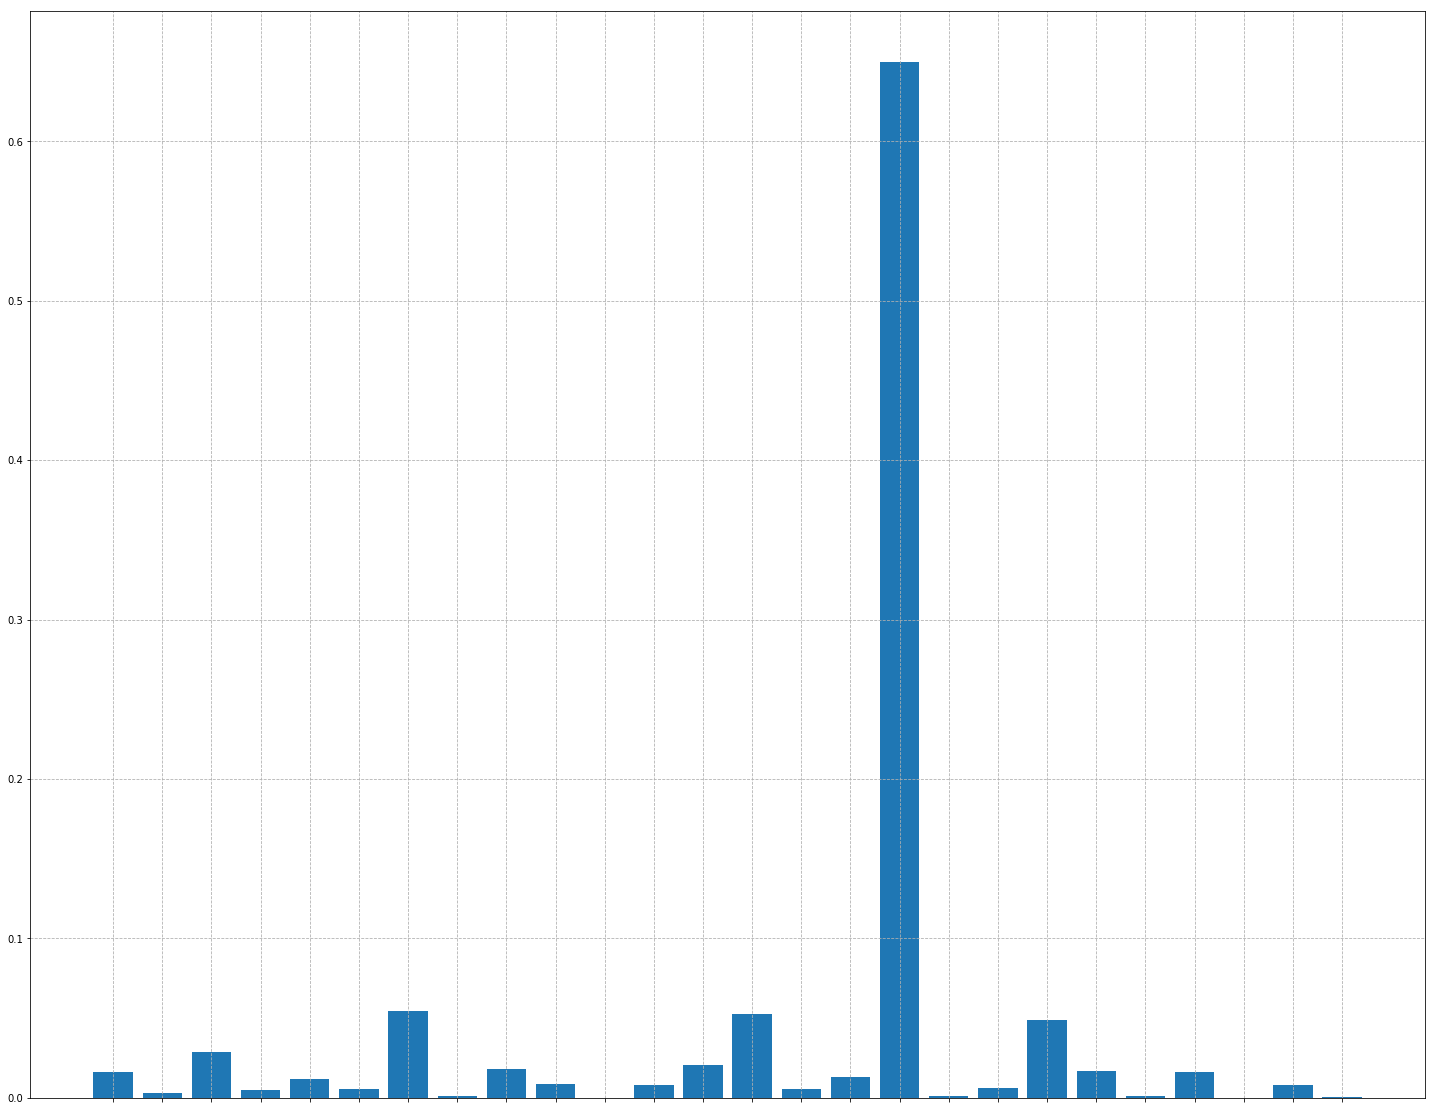

In [6]:
##################################################################################
# Solución analítica del cálculo de los pesos con el módelo clásico de Markowitz #
##################################################################################

def  wMa(rp,Pc):
    U= np.ones((Co.shape[0],1))
    E=np.transpose(np.array([Me]))
    A=np.matmul(np.transpose(U),np.matmul(np.linalg.inv(Co),E))
    B=np.matmul(np.transpose(E),np.matmul(np.linalg.inv(Co),E))
    C=np.matmul(np.transpose(U),np.matmul(np.linalg.inv(Co),U))
    D=B*C-A**2
    g=(1/D)*(B*np.matmul(np.linalg.inv(Co),U)-A*np.matmul(np.linalg.inv(Co),E))
    h=(1/D)*(C*np.matmul(np.linalg.inv(Co),E)-A*np.matmul(np.linalg.inv(Co),U))
    w=g+h*rp
    # Prueba
    w1 = np.asarray([])
    for i in range(len(w)):
        w1 = np.append(w1, w[i][0])
        
        wN=np.zeros(len(w))
    wS=np.sum(abs(w))
    for i in range(len(w)):        
        wN[i]=abs(w[i])/wS
    
    return w1,wN

print(wMa(np.mean(Me),Closing_Price))
print(np.sum(np.array([wMa(0.01,Closing_Price)[0]])))
print(np.sum(np.array([wMa(0.01,Closing_Price)[1]])))

plt.figure(figsize = ((25,20)))
label = np.arange(len(Lec(path)[1]))
plt.bar(label, wMa(0.01,Closing_Price)[1])
plt.xticks(label, Lec(path)[1], fontsize=10, rotation=30)
plt.grid(b = True, which = 'both', linestyle = '--')

plt.show()

In [74]:
#Variables de la función cuadrática de la librería CVXOPT
Q = cvx.matrix(Co)
P = cvx.matrix(np.zeros((Co.shape[0], 1)))
G = cvx.matrix(-1*np.identity((Co.shape[0])))
h = P
U = np.ones((Co.shape[0],1))
E = np.transpose(U)
ME= np.array([Me])
A = cvx.matrix(np.append(ME,E, axis=0))
rp= np.mean(Me)     #debemos definir el mejor entre todos
b = cvx.matrix(np.array([rp, 1]))

In [75]:
#Problema cuadrático, pesos positivos
from cvxopt import matrix, solvers
Q = cvx.matrix(Co)
P = cvx.matrix(np.zeros((Co.shape[0], 1)))
G = cvx.matrix(-1*np.identity((Co.shape[0])))
h = P
U = np.ones((Co.shape[0],1))
E = np.transpose(U)
ME = np.array([Me])
A = cvx.matrix(np.append(ME,E, axis=0))
rp = np.mean(Me)     #debemos definir el mejor entre todos
b = cvx.matrix(np.array([rp, 1]))
sol=solvers.qp(Q, p, G, h, A, b)
print(A)

     pcost       dcost       gap    pres   dres
 0:  5.3753e+03  5.3786e+03  1e+02  1e+01  1e+01
 1:  5.3760e+03  5.3961e+03  9e+01  9e+00  6e+00
 2:  5.5557e+03  5.5536e+03  2e+02  4e+00  3e+00
 3:  5.6689e+03  5.5987e+03  6e+02  3e+00  2e+00
 4:  5.6391e+03  5.6535e+03  4e+02  2e+00  1e+00
 5:  5.6209e+03  5.8792e+03  3e+02  1e+00  9e-01
 6:  5.6641e+03  6.2179e+03  3e+02  1e+00  7e-01
 7:  6.6760e+03  7.9480e+03  5e+02  5e-01  3e-01
 8:  7.1012e+03  8.5596e+03  1e+03  4e-01  3e-01
 9:  7.6237e+03  8.9569e+03  9e+02  3e-01  2e-01
10:  7.8984e+03  9.9514e+03  1e+03  3e-01  2e-01
11:  8.9113e+03  1.0741e+04  1e+03  2e-01  1e-01
12:  9.3766e+03  1.1420e+04  2e+03  1e-01  1e-01
13:  1.1346e+04  1.2396e+04  1e+03  5e-02  3e-02
14:  1.1928e+04  1.2596e+04  1e+03  3e-02  2e-02
15:  1.2831e+04  1.2907e+04  1e+03  1e-02  9e-03
16:  1.3098e+04  1.3099e+04  4e+01  4e-04  3e-04
17:  1.3106e+04  1.3105e+04  7e-01  5e-06  4e-06
18:  1.3105e+04  1.3105e+04  7e-03  5e-08  4e-08
Optimal solution foun